# Поведение пользователей в приложении

Цель нашего исследования: разобраться, как ведут себя пользователи нашего мобильного приложения  

Для этого нужно:  
* Изучить, как пользователи доходят до покупки
* Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах
* На каких именно шагах это происходит
* Исследовать результаты A/A/B-теста

Какие шаги были выполнены за время исследования:


1. Загрузили и подготовили данные к работе  
2. Изучили и проверили данные
3. Изучили воронку событий
4. Сделали A/A/B тест 

## Загрузка и подготовка данных

In [1]:
# Для начала загрузим необходимые библиотеки

import pandas as pd
import numpy as np
import seaborn as sns
import math as mth
from plotly import graph_objects as go
from scipy import stats as st
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Загрузим наш датасет

df = pd.read_csv('/Users/alekseivlasov/Desktop/project/9/logs_exp.csv', sep='\t')
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [3]:
df.shape

(244126, 4)

В нашем распоряжении ``244 126`` строк и ``4`` столбца

In [4]:
# Просмотрим общую информацию

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


В датафрейме нет пропусков, что уже хорошо. Название столбцов нужно будет изменить и привести к правильному стилю

In [5]:
df = df.rename(
    columns={'EventName':'event_name', 'DeviceIDHash':'user_id'
             , 'EventTimestamp':'event_dt', 'ExpId':'exp_id'}
)
df.columns

Index(['event_name', 'user_id', 'event_dt', 'exp_id'], dtype='object')

In [6]:
# Добавим столбец даты и времени, а также отдельный столбец дат

df.event_dt = pd.to_datetime(df.event_dt, unit='s')
df['date'] = df['event_dt'].dt.date

df.head()

,event_name,user_id,event_dt,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


Проверим таблицу на наличие дубликатов 

In [7]:
df.duplicated().sum()

413

Обнаружено 413 дублей, это меньше 0,01% от всех данных, поэтому убираем эти данные

In [8]:
df = df.drop_duplicates().reset_index(drop=True) #удаляем явные дубликаты

In [9]:
df.duplicated().sum()

0

Дубли могли возникнуть из-за технических багов

**Вывод:** Мы изучили датасет, проверили значения на пропуски, на дубли, и привели название столбов к правильному стилю  
Также добавили столбец даты и времени и отдельный столбец дат

## Изучение и проверка данных

Давайте посмотрим, сколько всего событий и пользователей в логах

In [10]:
print('Всего событий:', df['event_name'].count())
print('Всего пользователей:', df['user_id'].nunique())

Всего событий: 243713
Всего пользователей: 7551


Сколько в среднем событий приходится на пользователя

In [11]:
print('Среднее количество событий на одного пользователя:'
      , df['event_name'].count() / df['user_id'].nunique())

Среднее количество событий на одного пользователя: 32.27559263673685


Достаточно много событий для одного пользователя

Посмотрим, за какой период данными мы распологаем. Найдем максимальную и минимальную дату

In [12]:
print('Минимальная дата:', df['date'].min())
print('Максимальная дата:', df['date'].max())

Минимальная дата: 2019-07-25
Максимальная дата: 2019-08-07


Определим, с какого момента данные полные и отбросим более старые. Посмотрим, данными за какой период времени мы располагаем на самом деле

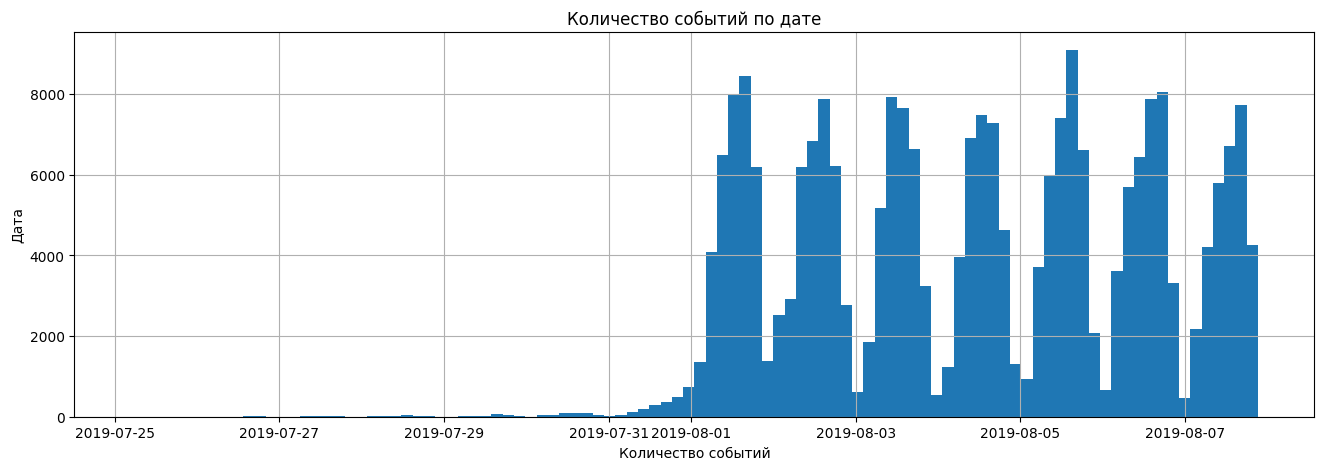

In [13]:
# Нарисуем график
fig, ax = plt.subplots()
df['event_dt'].hist(bins=100, figsize=(16, 5))
ax.set_title('Количество событий по дате')
ax.set_xlabel('Количество событий')
ax.set_ylabel('Дата')

plt.show()

Построили гистограмму, по которой видно, что до ``2019-08-01`` событий почти не было из-за малого количества пользователей. Логично отбросить этот временной период и начать анализировать с ``2019-08-01``

Перед тем, как отбросить старые данные, посмотрим, много ли событий и пользователей мы потеряем

In [14]:
df_old = df.query('event_dt < "2019-08-01 00:00:00"')
df_old.shape

(2826, 5)

Мы убираем 2828 событий, это 1% от основного датасета

In [15]:
# Отфильтруем данные по нашей стартовой дате и добавим в новую переменную
df_new = df.query('event_dt >= "2019-08-01 00:00:00"').reset_index(drop=True)
df_new.shape

(240887, 5)

Проверим, сколько пользователей мы потеряли

In [16]:
df['user_id'].nunique() - df_new['user_id'].nunique()

17

Потеря невелика

Проверим, что у нас есть пользователи из всех трёх экспериментальных групп

In [17]:
df_new['exp_id'].unique()

array([246, 247, 248])

Все на месте, отлично!

**Мы изучили и проверили данные:**
* Посмотрели количество событий: 244 126
* Количество пользователей: 7551 
* Среднее количество событий на одного пользователя: 32
* Нашли максимальную и минимальную дату исследования: 2019-07-25  -  2019-08-07
* Определили, с какой даты данные полные: 2019-08-01

## Изучение воронки событий

Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте

In [18]:
(df_new.groupby('event_name')
       .agg({'user_id':'count'})
       .sort_values(by='user_id', ascending=False)
       .reset_index()
)

,event_name,user_id
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


Событие ``Tutorial`` совершили всего 1039, это незначительное количество для t-test

Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей

In [19]:
event_user = (df_new.groupby('event_name')
       .agg({'user_id':'nunique'})
       .sort_values(by='user_id', ascending=False)
       .reset_index()
)

event_user

,event_name,user_id
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [20]:
df_new['user_id'].nunique()

7534

Посчитаем долю пользователей, которые хоть раз совершали событие

In [21]:
event_user['new_col'] = event_user['user_id'].shift(1,fill_value=7534) #Cоздали новый столбец и сдвинули значения
event_user['rate'] = round(event_user['user_id']/event_user['new_col'][0], 2) #Вычислили долю от общего количества
event_user = event_user.drop(columns=['new_col']) #Удалили ненужный столбец
event_user

,event_name,user_id,rate
0,MainScreenAppear,7419,0.98
1,OffersScreenAppear,4593,0.61
2,CartScreenAppear,3734,0.50
3,PaymentScreenSuccessful,3539,0.47
4,Tutorial,840,0.11


Посмотрим, какие событие у нас есть и в каком порядке они находятся:

* MainScreenAppear - Появление главного экрана
* OffersScreenAppear - Появление оффера
* CartScreenAppear - Переход в корзину
* PaymentScreenSuccessful - Оплата (это заключительное событие)
* Tutorial - обучение (его могут проходить не все, в воронке это событие учитывать не будем)

Все события выстраиваются в последовательную цепочку

По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем шаге)

In [22]:
#Отсортируем данные по событиям и количеству пользователей

funnel_step = (df_new.groupby('event_name')
       .agg({'user_id':'nunique'})
       .sort_values(by='user_id', ascending=False)
       .reset_index()
)
funnel_step

,event_name,user_id
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


Мы получили воронку с количеством пользователей на каждом этапе события, теперь нужно получить долю от прошлого

In [23]:
# Cоздали новый столбец и сдвинули значения
funnel_step['new_col'] = funnel_step['user_id'].shift(1, fill_value=7419)
# Вычислили долю от предыдущего шага
funnel_step['rate_by_step'] = round(funnel_step['user_id']/funnel_step['new_col'], 2)
# Удалили ненужный столбец
funnel_step = funnel_step.drop(columns=['new_col'])
funnel_step

,event_name,user_id,rate_by_step
0,MainScreenAppear,7419,1.00
1,OffersScreenAppear,4593,0.62
2,CartScreenAppear,3734,0.81
3,PaymentScreenSuccessful,3539,0.95
4,Tutorial,840,0.24


Больше всего теряется пользователей на шаге ``OffersScreenAppear``

In [24]:
print('Доля от первого события до оплаты:', round(funnel_step['user_id'][3]/funnel_step['user_id'][0], 2))

Доля от первого события до оплаты: 0.48


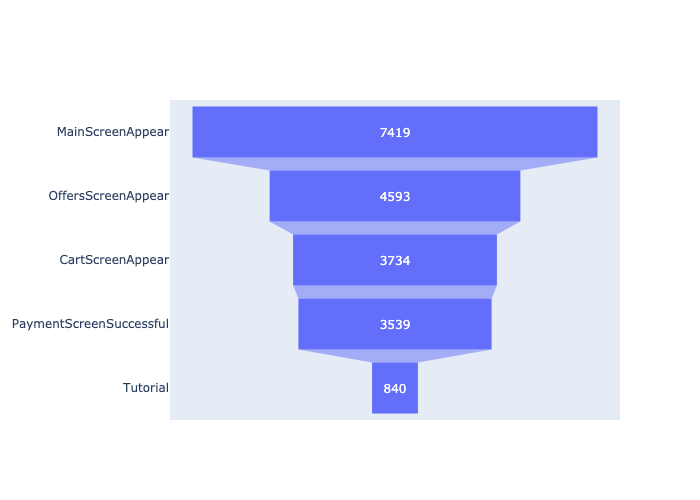

In [25]:
# Нарисуем воронку

fig = go.Figure(
    go.Funnel(
        y = funnel_step['event_name'],
        x = funnel_step['user_id']
    )
)
fig.show('png')

**Мы изучили воронку событий:**

* Посмотрели, какие события есть в логах, как часто они встречаются и отсортировали события по частоте
* Посчитали, сколько пользователей совершали каждое из этих событий
* Посчитали долю пользователей, которые хоть раз совершали событие
* Построили воронку из событий
* По воронке событий посчитали, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем шаге)

## Результаты эксперимента

*Нулевая гипотеза звучит так:* Разницы между группами в долях нет  
*Альтернативныя гипотеза:* Разница между группами в долях есть

Начнем с просмотра количества пользователей в каждой группе

In [26]:
all_users = df_new.groupby('exp_id').agg({'user_id':'nunique'}).reset_index()
all_users

,exp_id,user_id
0,246,2484
1,247,2513
2,248,2537


Количество пользователей делится на 3 равные части по каждой группе теста  
246 и 247 - контрольные группы, а 248 - экспериментальная

Проверим, есть ли пользователи, которые относятся не к одной группе

In [27]:
group_check= df_new.groupby(by='user_id').agg({'exp_id':'nunique'})
group_check.head()

,exp_id
user_id,
6888746892508752,1
6909561520679493,1
6922444491712477,1
7435777799948366,1
7702139951469979,1


In [28]:
group_check.query('exp_id > 1')

,exp_id
user_id,


Пользователей, которые состоят не в одной группе нет, это хорошо

**Проверим 2 контрольные группы**  

In [29]:
# Для начала сгруппируем данные 

# пользователи из группы 246
group246 = df_new.query('exp_id == 246')\
    .groupby('event_name', as_index=False)['user_id'].nunique()\
    .sort_values(by='user_id', ascending=False)\
    .reset_index(drop=True)
group246.columns = ('event_name', '246')

# пользователи из группы 247
group247 = df_new.query('exp_id == 247')\
    .groupby('event_name', as_index=False)['user_id'].nunique()\
    .sort_values(by='user_id', ascending=False)\
    .reset_index(drop=True)
group247.columns = ('event_name', '247')

# пользователи из группы 248
group248 = df_new.query('exp_id == 248')\
    .groupby('event_name', as_index=False)['user_id'].nunique()\
    .sort_values(by='user_id', ascending=False)\
    .reset_index(drop=True)
group248.columns = ('event_name', '248')

all_groups = group246.merge(group247, on='event_name').merge(group248, on='event_name')
all_groups = all_groups.drop(labels=[4], axis=0,) # удалим туториал
all_groups

,event_name,246,247,248
0,MainScreenAppear,2450,2476,2493
1,OffersScreenAppear,1542,1520,1531
2,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181


Самое популярное событие - ``MainScreenAppear``, оно же первое. С него мы и начнем

Число пользователей, совершивших это событие в каждой из контрольных групп:

In [30]:
print('В группе 246:', all_groups['246'][0])
print('В группе 247:', all_groups['247'][0])

В группе 246: 2450
В группе 247: 2476


Теперь посчитаем долю пользователей, совершивших событие ``MainScreenAppear``

In [31]:
print(
    'Доля пользователей в группе 246:', round(all_groups['246'][0]/all_users['user_id'][0], 3)
)
print(
    'Доля пользователей в группе 247:', round(all_groups['247'][0]/all_users['user_id'][1], 3)
)

Доля пользователей в группе 246: 0.986
Доля пользователей в группе 247: 0.985


Доля пользователей, совершивших событие практически одинакова. Проверим, будет ли отличие между грппами статистически достоверно

In [32]:
alpha = .05 # критический уровень статистической значимости

successes = np.array([2450, 2476])
trials = np.array([2484, 2513])

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(
    p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])
)

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)
    
if p_value < alpha:
    print('Отвергаем нулевую гипотезу по событию MainScreenAppear: между долями есть значимая разница')
else:
    print(
         'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проделаем то же самое для всех событий, для этого, обернем наш тест в функцию

Для каждой контрольной группы добавим в список те значения, которые нужны для теста

In [33]:
group_246 = list(all_groups['246'])
group_247 = list(all_groups['247'])
events = list(all_groups['event_name'])

print(group_246)
print(group_247)
print(events)

[2450, 1542, 1266, 1200]
[2476, 1520, 1238, 1158]
['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']


Создаем функцию, с помощью которой будем делать тест по каждому событию

In [34]:
def test_aa (group_1, group_2, trials_1, trials_2, events):

    alpha = .05 # критический уровень статистической значимости

    successes = np.array([group_1, group_2])
    trials = np.array([trials_1, trials_2])

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])
    )

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)
    
    if p_value < alpha:
        print(f'Отвергаем нулевую гипотезу по событию {events}: между долями есть значимая разница')
    else:
        print(
             f'Не получилось отвергнуть нулевую гипотезу по событию {events}, нет оснований считать доли разными'
        )

In [35]:
# Cоздадим цикл
for group_1, group_2, event in zip(group_246, group_247, events):
    test_aa (group_1, group_2, 2484, 2513, event)
    print()

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear, нет оснований считать доли разными

p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear, нет оснований считать доли разными

p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear, нет оснований считать доли разными

p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу по событию PaymentScreenSuccessful, нет оснований считать доли разными



В контрольных групах с высокой степенью достоверности одинаковый результат, поэтому нет оснований счтитать эти группы разными  
Разбиение на группы работает корректно

**Проверим экспериментальную группу**

Аналогично поступим с группой с изменённым шрифтом ``248``. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию

In [36]:
# Для группы 248 создадим нужный список для теста
group_248 = list(all_groups['248'])
print(group_248)

[2493, 1531, 1230, 1181]


In [37]:
# Сделаем тест по группам 246 и 248
for group_1, group_2, event in zip(group_246, group_248, events):
    test_aa (group_1, group_2, 2484, 2537, event)
    print()

p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear, нет оснований считать доли разными

p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear, нет оснований считать доли разными

p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear, нет оснований считать доли разными

p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу по событию PaymentScreenSuccessful, нет оснований считать доли разными



Между группами 246 и 248 не получилось отвергнуть нулевую гипотезу по каждому событию

In [38]:
# Сделаем тест по группам 247 и 248
for group_1, group_2, event in zip(group_247, group_248, events):
    test_aa (group_1, group_2, 2513, 2537, event)
    print()

p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear, нет оснований считать доли разными

p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear, нет оснований считать доли разными

p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear, нет оснований считать доли разными

p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу по событию PaymentScreenSuccessful, нет оснований считать доли разными



Между группами 247 и 248 картина не поменялась

Теперь объединим результаты контрольных групп и сраним с группой 248

In [39]:
all_groups['246_247'] = all_groups['246'] + all_groups['247']
all_groups

,event_name,246,247,248,246_247
0,MainScreenAppear,2450,2476,2493,4926
1,OffersScreenAppear,1542,1520,1531,3062
2,CartScreenAppear,1266,1238,1230,2504
3,PaymentScreenSuccessful,1200,1158,1181,2358


In [40]:
# Создадим новый список
group_246_247 = list(all_groups['246_247'])
print(group_246_247)

[4926, 3062, 2504, 2358]


In [41]:
# Объединим количество пользователей
users_246_247 = all_users['user_id'][0] + all_users['user_id'][1]
users_246_247

4997

In [42]:
# Сделаем тест по контрольным группам и группе 248
for group_1, group_2, event in zip(group_246_247, group_248, events):
    test_aa (group_1, group_2, 4997, 2537, event)
    print()

p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear, нет оснований считать доли разными

p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear, нет оснований считать доли разными

p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear, нет оснований считать доли разными

p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу по событию PaymentScreenSuccessful, нет оснований считать доли разными



При тестировании объединенных контрольных группах и группы 248 мы точно такой же результат, как и в прошлых тестах

**Вывод:**  
Изменение шрифта не повлияло за собой изменение в конверсиях

Мы делали тест с уровнем значимости 0.05, и сделали 16 проверок статистических гипотез  
Критерий *alpha = 0,05* был задан исходя из общепринятых порговых значений (5% и 1%)

Попробуем повторить тест с обединенными контрольными группами и группой 248, но в этот раз выберим критерий *alpha = 0.01*

In [43]:
# Создадим новую функцию
def test_ab_new (group_1, group_2, events):

    alpha = .01 # критический уровень статистической значимости

    successes = np.array([group_1, group_2])
    trials = np.array([4997, 2537])

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])
    )

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)
    
    if p_value < alpha:
        print(f'Отвергаем нулевую гипотезу по событию {events}: между долями есть значимая разница')
    else:
        print(
             f'Не получилось отвергнуть нулевую гипотезу по событию {events}, нет оснований считать доли разными'
        )

In [44]:
# Сделаем тест по контрольным группам и группе 248
for group_1, group_2, event in zip(group_246_247, group_248, events):
    test_ab_new (group_1, group_2, event)
    print()

p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear, нет оснований считать доли разными

p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear, нет оснований считать доли разными

p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear, нет оснований считать доли разными

p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу по событию PaymentScreenSuccessful, нет оснований считать доли разными



C критерием *alpha = 0.01* у нас получился точно такой же результат, поэтому тест можно считать выполненным

## Вывод

**Задача исследования была:** разобраться, как ведут себя пользователи нашего мобильного приложения и провести A/A/B тесты  

1. Загрузили и подготовили данные к работе

  * Данные составили: ``244 126`` строк и ``4`` столбца
  * Пропусков не обнаружено 
  * Поменяли название столбцов и привели к правильному стилю
  * Изменили тип данных в нужных столбцах  
  

2. Изучили и проверили данные

  * Всего событий: 244126
  * Всего пользователей: 7551
  * Среднее количество событий на одного пользователя: 32
  * Минимальная дата: 2019-07-25
  * Максимальная дата: 2019-08-07
  * Определили, с какой даты данные полные: 2019-08-01  
  
   
3. Изучили воронку событий

  * Посмотрели, какие события есть в логах, как часто они встречаются и отсортировали события по частоте
  * Посчитали, сколько пользователей совершали каждое из этих событий
  * Посчитали долю пользователей, которые хоть раз совершали событие
  * Построили воронку из событий
  * По воронке событий посчитали, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем шаге)
  
  
4. Реузультат A/A/B теста 

  * Мы проверили контрольные группы между собой, разницы обнаруженно не было 
  * Сделали тест каждой котрольной группы по отдельности с группой 248 - ситуация не поменялось
  * Объединили две контрольные группы и сравнили с группой 249 - разницы не обнаружили
  * Изменение шрифта не повлияло за собой изменение в конверсиях
  * Новый шрифт можно оставить, однако это не увеличит показатели